# Firstly Lets train a GAN

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time
import PIL
from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
g_loss = []
d_loss = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    g,d = 0,0
    for image_batch in dataset:
      loss = train_step(image_batch)
      g += loss[0]
      d += loss[1]
    g_loss.append(g)
    d_loss.append(d)

    display.clear_output(wait=True)
    generate_images(generator, seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

def generate_images(model, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.show()

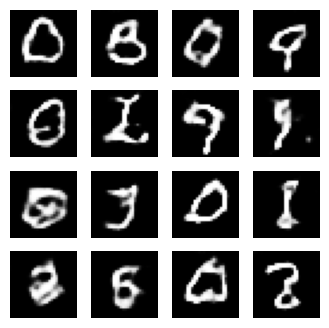

Time for epoch 50 is 11.153778076171875 sec


In [ ]:
train(train_dataset, EPOCHS)

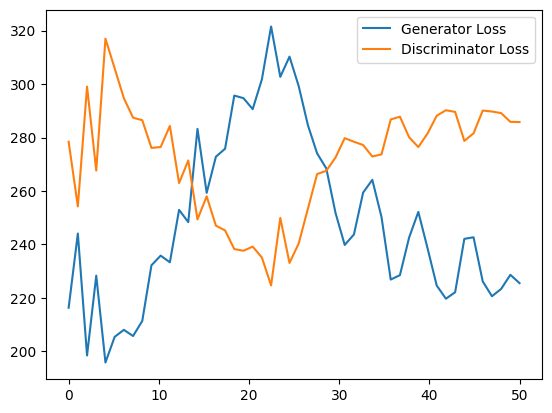

In [ ]:
plt.plot(np.linspace(0,50,50),g_loss)
plt.plot(np.linspace(0,50,50),d_loss)
plt.legend(['Generator Loss','Discriminator Loss'])
plt.show()

In [38]:
print("Minimum generator loss:", min(g_loss).numpy())
print("Minimum discriminator loss:", min(d_loss).numpy())
print("Minimum Total loss:", (min(g_loss)+min(d_loss)).numpy())

Minimum generator loss: 195.80879
Minimum discriminator loss: 224.6584
Minimum Total loss: 420.4672


#Now Lets try to make the model better!

In [20]:
def make_better_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [21]:
better_discriminator = make_better_discriminator_model()

In [30]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

In [31]:
g_loss_v2 = []
d_loss_v2 = []

@tf.function
def train_step_v2(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = better_discriminator(images, training=True)
      fake_output = better_discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, better_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, better_discriminator.trainable_variables))

    return [gen_loss, disc_loss]

def train_v2(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    g,d = 0,0
    for image_batch in dataset:
      loss = train_step_v2(image_batch)
      g += loss[0]
      d += loss[1]
    g_loss_v2.append(g)
    d_loss_v2.append(d)

    display.clear_output(wait=True)
    generate_images(generator, seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

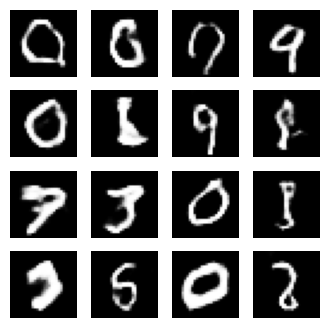

Time for epoch 50 is 16.098159074783325 sec


In [32]:
train_v2(train_dataset, EPOCHS)

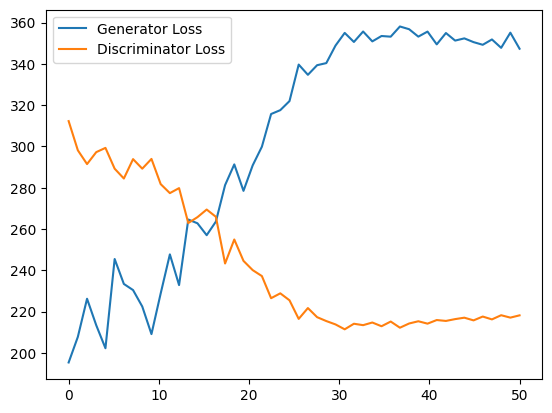

In [33]:
plt.plot(np.linspace(0,50,50),g_loss_v2)
plt.plot(np.linspace(0,50,50),d_loss_v2)
plt.legend(['Generator Loss','Discriminator Loss'])

In [39]:
print("Minimum generator loss:", min(g_loss_v2).numpy())
print("Minimum discriminator loss:", min(d_loss_v2).numpy())
print("Minimum Total loss:", (min(g_loss_v2)+min(d_loss_v2)).numpy())

Minimum generator loss: 195.34668
Minimum discriminator loss: 211.41779
Minimum Total loss: 406.76447


As we can see, the discriminator loss decreased as well as the images produced are much more recognisable. We can further modify the generator to decrease the Total loss even further.